# Deep Learning Course 

## Assignment 3 

### Assignment Goals:

* Implementing and improving RNN based language models.
* Implementing and applying a Recurrent Neural Network on text classification problem.


In this assignment, you will implement RNN-based language models and compare extracted word representation from different models. You will also compare two different training methods for sequential data: Truncated Backpropagation Through Time __(TBTT)__ and Backpropagation Through Time __(BTT)__. 
Also, you will be asked to apply Vanilla RNN to capture word representations and solve a text classification problem. 


### DataSets

You will use two datasets, an English Literature dataset for language model task (part 1 to 4) and the 20Newsgroups dataset for text classification (part 5). 

### Requirements

1. **(30 points) Implement a RNN based language model.**

    Implement the RNN based language model described by [Mikolov et al.](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf), also called **Elman network**. The Elman network contains input, hidden and output layer and is trained by standard backpropagation (TBTT with $τ = 1$) using the cross-entropy loss. 

      * The input vector $x(t)$ at time $t$ consists of the current word while using 1-of-N coding (thus its size is equal to the size of the vocabulary) $w(t)$ and a vector $s(t − 1)$ which represents output values in the hidden layer from the previous time step $t-1$.
      $$x(t) = w(t) + s(t-1)$$
      
      * The hidden layer is a fully connected sigmoid layer with size 500. 
      $$s_j(t) = f(\sum_i x_i(t)u_{ji} )$$
      Here $u$ is the parameter matrix of hidden layer, $f$ is the sigmoid activation function. 
      
      * The softmax output layer captures a valid probability distribution.
      $$y_k(t) = g(\sum_j s_j(t)v_{kj})$$
      Here $v$ is the parameter matrix of output layer, $g$ is the softmax function. 
      
      * The model is trained with truncated backpropagation through time (TBTT) with $τ = 1$: the weights of the network are updated based on the error vector computed only for the current time step. 
      
   Train the language model on the given English Literature dataset, report the model cross-entropy loss on the train set. Visualize the cross-entropy loss during training using a curve line. Your curve line should demonstrate that the loss value converges. 
   
   Use nltk.word_tokenize to tokenize the documents. For initialization, $s(0)$ can be set to a vector of small values. Note that we are not interested in the *dynamic model* mentioned in the original paper. 


2. **(20 points) Train the Elman network with BTT.**

    TBTT has less computational cost and memory needs in comparison with **backpropagation through time algorithm (BTT)**. These benefits come at the cost of losing long term dependencies ([reference](https://arxiv.org/abs/1705.08209)). TBTT is rarely used until now, we use BTT instead.

    Train your implemented Elman network with BTT, then compare the computational costs and performance of BTT and TBTT training.  For training the Elman-type RNN with BTT, one option is to perform mini-batch gradient descent with exactly one sentence per mini-batch. (Hints: The input  size will be (1, Sentence Length) ). 

   * Split the document into sentences (you can use nltk.tokenize.sent_tokenize. The natural language toolkit (nltk) can be installed using the command 'pip install nltk').
   * For each sentence, perform one pass that computes the mean/sum loss for this sentence; then perform a gradient update for the whole sentence. (So the mini-batch size varies for the sentences with different lengths). You can truncate long sentences to fit the data in memory. 
   * Report the model cross-entropy loss.Visualize the cross-entropy loss during training using a curve line. Your curve line should demonstrate that the loss value converges. 

3. **(30 points) Improve your Elman network with GRU.**

    (a) Gated Recurrent Unit: It does not seem that simple recurrent neural networks can capture truly exploit context information with long dependencies, because of the problem of gradient vanishing and exploding. To solve this problem, gating mechanisms for recurrent neural networks were introduced. (15 points)

    Try to learn your last model (Elman + BTT) with the SimpleRnn unit replaced with a **Gated Recurrent Unit (GRU)**. Report the model cross-entropy loss.  Visualize the cross-entropy loss during training using a curve line. Your curve line should demonstrate that the loss value converges. Compare your results in terms of cross-entropy loss with two other approaches (part 1 and 2). 

    (b) Text generation: Use each model to generate 10 synthetic sentences of 15 words each. Discuss the quality of the sentences generated - do they look like proper English? Do they match the training set? (15 points)
    
    Text generation from a given language model can be done using the following iterative process:
   - Set sequence = \[first_word\], chosen randomly.
   - Select a new word based on the sequence so far, add this word to the sequence, and repeat. At each iteration, select the word with maximum probability given the sequence so far. The trained language model outputs this probability. 

4. **(20 points) Implement a text classification model.**

    We are aiming to learn an RNN model that predicts document categories given its content (text classification). For this task, we will use the 20Newsgroups dataset. The 20Newsgroupst contains messages from twenty newsgroups.  We selected four major categories (comp, politics, rec, and religion) comprising around 13k documents altogether. Your model should learn word representations to support the classification task. For solving this problem modify the **Elman network** architecture and simple RNN such that the last layer is a softmax layer with just 4 output neurons (one for each category). 

    * Download the 20Newsgroups dataset, and use the below helper function data_loader() to read in the dataset.
    * Split the data into a training set (90%) and validation set (10%). 
    * Implement your text classification model, and train the model on 20Newsgroups training set.
    * Report your accuracy results on the validation set. Try to achieve $\geq 80\%$ validation accuracy. (5 points) 

### Submission Notes

Please use Jupyter Notebook. The notebook should include the final code, results and your answers. You should submit your Notebook in (.pdf or .html) and .ipynb format. (penalty 10 points) 

To reduce the parameters, you can merge all words that occur less often than a threshold into a special rare token (\__unk__).

**Instructions：**

The university policy on academic dishonesty and plagiarism (cheating) will be taken very seriously in this course. Everything submitted should be your own writing or coding. You must not let other students copy your work. Spelling and grammar count.

Your assignments will be marked based on correctness, originality (the implementations and ideas are from yourself), and test performance.



## Your Implementation

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import tensorflow as tf

# use GPU
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

colab_path = '/content/gdrive/MyDrive/'

Found GPU at: /device:GPU:0


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import os
import os.path
import glob
import string
import nltk
# nltk.download()

tf.random.set_seed(0)
np.random.seed(0)

### 1. Implement a RNN based language model

Data Preprocessing

In [ ]:
path = 'English Literature.txt'

# path = colab_path + path

# read file
with open(path, encoding = 'utf-8') as f:
    text = f.read()


# handle lower case
text = text.lower()

# handle punctuation
# punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
 
# no_punc = ""
# for char in text:
#     if char not in punctuations:
#         no_punc = no_punc + char
# text = no_punc

# tokenizer = nltk.RegexpTokenizer(r"\w+")
# new_words = tokenizer.tokenize(sentence)

tokens = nltk.word_tokenize(text)
cleaned_tokens = tokens

# build vocablary
# represent rare words by unkown token
min_count = 0 # 1 # threshold for rare words 
# I set min_count to 0 to disable this feature
unknown_token = '<unk>' # __unk__
word2index = {unknown_token: 0}
index2word = [unknown_token]

filtered_words = 0
counter = Counter(cleaned_tokens)

for word, count in counter.items():
    if count > min_count:
        index2word.append(word)
        word2index[word] = len(word2index)
    else:
        filtered_words += 1

num_words = len(word2index)

print('vocabulary size: ', num_words)
print('filtered words: ', filtered_words)


# convert list of strings(tokens) to list of integers
data_sequence =[]
for t in tokens:
    if t in index2word:
        data_sequence.append(word2index[t])
    else:
        data_sequence.append(0)


# one-hot encoding for data sequence
data_sequence_encode = np.zeros((len(data_sequence), num_words), dtype=np.int8)

for i in range(len(data_sequence)):
    data_sequence_encode[i, data_sequence[i]] = 1


# creating x and y
X = []
y = []

# Iterate through the sequences of tokens
for i in range(1, len(data_sequence)):
        
    X.append(data_sequence[i-1:i])
    y.append(data_sequence_encode[i, :])
        
X = np.array(X)
y = np.array(y)

print("input shape:", X.shape)
print("output shape:", y.shape)

vocabulary size:  12443
filtered words:  0
input shape: (254521, 1)
output shape: (254521, 12443)


Network implementation:

In [ ]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=num_words, output_dim=500))
model.add(layers.SimpleRNN(500, activation='sigmoid'))
# model.add(layers.Dense(500, activation='sigmoid'))
model.add(layers.Dense(num_words, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 500)         6224000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 500)               500500    
_________________________________________________________________
dense_1 (Dense)              (None, 12448)             6236448   
Total params: 12,960,948
Trainable params: 12,960,948
Non-trainable params: 0
_________________________________________________________________


Network training:

In [ ]:
epochs = 15
batch_size = 64
# opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
value_epoches = model.fit(X, y, batch_size=batch_size, epochs=epochs)

print("_________________________________________________________________")
score = model.evaluate(X, y, verbose=0)
print("train loss:", score[0])

Epoch 1/15
3977/3977 [==============================] - 250s 63ms/step - loss: 6.1693 - accuracy: 0.1120
Epoch 2/15
3977/3977 [==============================] - 251s 63ms/step - loss: 5.2289 - accuracy: 0.1522
Epoch 3/15
3977/3977 [==============================] - 253s 64ms/step - loss: 4.9552 - accuracy: 0.1655
Epoch 4/15
3977/3977 [==============================] - 249s 63ms/step - loss: 4.7474 - accuracy: 0.1716
Epoch 5/15
3977/3977 [==============================] - 248s 62ms/step - loss: 4.5719 - accuracy: 0.1770
Epoch 6/15
3977/3977 [==============================] - 249s 63ms/step - loss: 4.4493 - accuracy: 0.1787
Epoch 7/15
3977/3977 [==============================] - 249s 62ms/step - loss: 4.3529 - accuracy: 0.1803
Epoch 8/15
3977/3977 [==============================] - 246s 62ms/step - loss: 4.2989 - accuracy: 0.1796
Epoch 9/15
3977/3977 [==============================] - 246s 62ms/step - loss: 4.2577 - accuracy: 0.1825
Epoch 10/15
3977/3977 [==============================] 

Loss visualization:

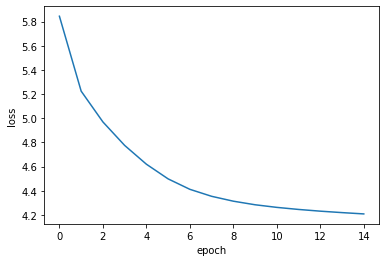

In [ ]:
plt.plot(value_epoches.history['loss'],label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### 2. Train the Elman network with BTT

Data Preprocessing

In [ ]:
path = 'English Literature.txt'
# path = colab_path + path

# read file
with open(path, encoding = 'utf-8') as f:
    text = f.read()


# handle lower case
text = text.lower()

# this gives us a list of sentences
sen_text = nltk.tokenize.sent_tokenize(text)

max_sen_length = 40 # It can be higher but I had RAM constraintd on google colab

X = []
y = []
# now loop over each sentence and tokenize it separately
for sentence in sen_text:
    tokenized_text = nltk.word_tokenize(sentence)
    seq = []

    for w in tokenized_text:
        if w in index2word:
            index = word2index[w]
        else:
            index = 0 # unknown
        seq.append(index)
        
    seq = np.asarray(seq)
    X.append(seq[:-1])
    y.append(seq[1:])

X = np.asarray(X)
y = np.asarray(y)


# https://www.tensorflow.org/guide/keras/masking_and_padding
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_sen_length, padding="post", truncating = 'post')
y = tf.keras.preprocessing.sequence.pad_sequences(y, maxlen=max_sen_length, padding="post", truncating = 'post')
y = tf.keras.utils.to_categorical(y, num_words)

X = np.expand_dims(X, axis=-1)

print("input shape:", X.shape)
print("output shape:", y.shape)


/Users/mahsa/anaconda3/envs/cmpt728/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


input shape: (12449, 40, 1)
output shape: (12449, 40, 12443)


In [ ]:
model2 = keras.Sequential()
model2.add(layers.Embedding(num_words, max_sen_length, input_length=max_sen_length, mask_zero=True))
model2.add(layers.Masking(mask_value=0))
model2.add(layers.SimpleRNN(500, batch_input_shape=(1, max_sen_length, num_words), return_sequences=True, activation='sigmoid'))
# model2.add(layers.Dense(500, activation='sigmoid'))
model2.add(layers.TimeDistributed(layers.Dense(num_words, activation="softmax")))
# model2.summary()

In [ ]:
epochs = 15
batch_size = 64

# opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
value_epoches2 = model2.fit(X, y, batch_size=batch_size, epochs=epochs)

print("_________________________________________________________________")
score = model2.evaluate(X, y, verbose=0)
print("train loss:", score[0])

Epoch 1/15
195/195 [==============================] - 258s 1s/step - loss: 4.1758 - accuracy: 0.5483
Epoch 2/15
195/195 [==============================] - 251s 1s/step - loss: 2.5551 - accuracy: 0.6185
Epoch 3/15
195/195 [==============================] - 258s 1s/step - loss: 2.3994 - accuracy: 0.6302
Epoch 4/15
195/195 [==============================] - 302s 2s/step - loss: 2.2839 - accuracy: 0.6384
Epoch 5/15
195/195 [==============================] - 256s 1s/step - loss: 2.2448 - accuracy: 0.6383
Epoch 6/15
195/195 [==============================] - 242s 1s/step - loss: 2.2107 - accuracy: 0.6388
Epoch 7/15
195/195 [==============================] - 234s 1s/step - loss: 2.1681 - accuracy: 0.6417
Epoch 8/15
195/195 [==============================] - 232s 1s/step - loss: 2.1226 - accuracy: 0.6456
Epoch 9/15
195/195 [==============================] - 231s 1s/step - loss: 2.0797 - accuracy: 0.6491
Epoch 10/15
195/195 [==============================] - 237s 1s/step - loss: 2.0406 - accura

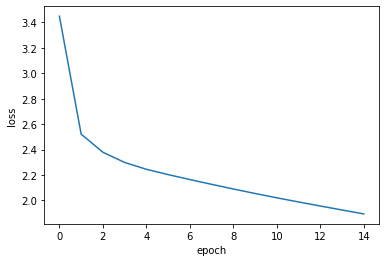

In [ ]:
plt.plot(value_epoches2.history['loss'],label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### 3. Improve your Elman network with GRU

#### (a) Gated Recurrent Unit:

In [ ]:
model3 = keras.Sequential()
model3.add(layers.Embedding(num_words, max_sen_length, input_length=max_sen_length, mask_zero=True))
model3.add(layers.Masking(mask_value=0))
model3.add(layers.GRU(500, batch_input_shape=(1, max_sen_length, num_words), return_sequences=True, activation='sigmoid'))
# model3.add(layers.Dense(500, activation='sigmoid'))
model3.add(layers.TimeDistributed(layers.Dense(num_words, activation="softmax")))
# model3.summary()

In [ ]:
epochs = 15
batch_size = 64

# opt = keras.optimizers.Adam(learning_rate=0.001)

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
value_epoches3 = model3.fit(X, y, batch_size=batch_size, epochs=epochs)

print("_________________________________________________________________")
score = model3.evaluate(X, y, verbose=0)
print("train loss:", score[0])
# print("train accuracy:", score[1])

Epoch 1/15
195/195 [==============================] - 266s 1s/step - loss: 4.1140 - accuracy: 0.5365
Epoch 2/15
195/195 [==============================] - 256s 1s/step - loss: 2.5552 - accuracy: 0.6225
Epoch 3/15
195/195 [==============================] - 256s 1s/step - loss: 2.4331 - accuracy: 0.6299
Epoch 4/15
195/195 [==============================] - 257s 1s/step - loss: 2.3246 - accuracy: 0.6378
Epoch 5/15
195/195 [==============================] - 310s 2s/step - loss: 2.2685 - accuracy: 0.6381
Epoch 6/15
195/195 [==============================] - 292s 1s/step - loss: 2.2199 - accuracy: 0.6388
Epoch 7/15
195/195 [==============================] - 288s 1s/step - loss: 2.1679 - accuracy: 0.6424
Epoch 8/15
195/195 [==============================] - 312s 2s/step - loss: 2.1176 - accuracy: 0.6455
Epoch 9/15
195/195 [==============================] - 310s 2s/step - loss: 2.0712 - accuracy: 0.6497
Epoch 10/15
195/195 [==============================] - 308s 2s/step - loss: 2.0278 - accura

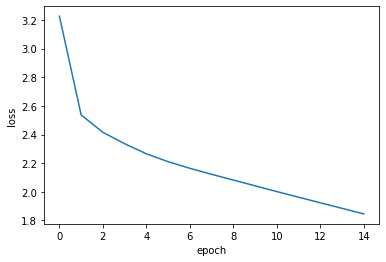

In [ ]:
plt.plot(value_epoches3.history['loss'],label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### (b) Text generation:

The quality isn't very high quality and I could train the network for longer time if I have more time to get the better results. But somehow some parts of sentences look like proper english. In general, model 2 and 3 are better since they consider long term dependencies and you can see some parts of generated sequences have a proper structure. Some parts match the training set.

In [ ]:
from numpy import random
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)


def check_prediction(model, n_sentence, n_words):
    
    for i in range(n_sentence):
        seq = []
        seq_print = ''
        index = random.randint(num_words-1)+1
        first_word = index2word[index]
        seq.append(first_word)
        seq_print += first_word + ' '
        x = np.array([index])
        
        for j in range(1, n_words):
            prediction = model.predict(x[np.newaxis, :], verbose = 0)
            index = np.argmax(prediction)
            next_word = index2word[index]
            seq_print += next_word + ' '
            x = np.array([index])
        
        print(seq_print)
        
def check_prediction_seq(model, n_sentence, n_words):
    
    for i in range(n_sentence):
        indices = []
        seq_print = ''
        index = random.randint(num_words-1)+1
        seq = [[index]]
        indices = [index]
        x = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sen_length, padding="post", truncating = 'post')
        first_word = index2word[index]
        seq.append(first_word)
        seq_print += first_word + ' '
        
        for j in range(1, n_words):
            prediction = model.predict(x, verbose = 0)
            next_p = prediction[0, j-1, :]
            index = np.argmax(next_p)
            next_word = index2word[index]
            seq_print += next_word + ' '
            x = np.array([index])
            indices.append(index)
            seq = [indices]
            x = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sen_length, padding="post", truncating = 'post')
        
        print(seq_print)


In [ ]:
# model 1: generate 10 synthetic sentences of 15 words
print("Model 1: 10 synthetic sentences of 15 words:\n")
check_prediction(model, n_sentence = 10, n_words = 15)

Model 1: 10 synthetic sentences of 15 words:

yawn , and , and , and , and , and , and , and 
governs lord , and , and , and , and , and , and , 
freed . king richard iii : i am i am i am i am i 
forward , and , and , and , and , and , and , and 
bade me , and , and , and , and , and , and , 
amazon . king richard iii : i am i am i am i am i 
clears , and , and , and , and , and , and , and 
honesty , and , and , and , and , and , and , and 
prelate bishop of the king richard iii : i am i am i am i 
signories it is the king richard iii : i am i am i am i 


In [ ]:
# model 2: generate 10 synthetic sentences of 15 words
print("Model 2: 10 synthetic sentences of 15 words:\n")
check_prediction_seq(model2, n_sentence = 10, n_words = 15)

Model 2: 10 synthetic sentences of 15 words:

milder , i 'll be a man , and i 'll be a man , 
arrests , i 'll be a man , and i 'll be a man , 
conceiving you , sir , i 'll be a man , and i 'll be 
to-day , i 'll be a man , and i 'll be a man , 
oxford : i 'll be a man , and i 'll be a man , 
hitherto , and i am a man , and i am a man , and 
rote and i 'll be a man , and i 'll be a man , 
injured me , and i am not to be a man , and i 'll 
guildfords are a man , and i am not to be a man , and 
forest , i 'll be a man , and i 'll be a man , 


In [ ]:
# model 3: generate 10 synthetic sentences of 15 words
print("Model 3: 10 synthetic sentences of 15 words:\n")
check_prediction_seq(model3, n_sentence = 10, n_words = 15)

Model 3: 10 synthetic sentences of 15 words:

milder , i 'll not be a man . ' the world , and the 
arrests , i 'll not be a man . ' the world , and the 
conceiving you , my lord , and i 'll be a king , and , 
to-day , i 'll not be a man . ' the world , and , 
oxford : i 'll not be so , and i 'll be satisfied . ' 
hitherto 's a matter , and i 'll not be a man . ' the 
rote : i 'll not be a man . ' the world , and the 
injured me , my lord , i 'll not be a king , and , 
guildfords , my lord , i 'll not be a man . ' the world 
forest , i 'll not be a man . ' the people , and , 


### 4. Implement a text classification model

Validation accuarcy = 71%

In [4]:
"""This code is used to read all news and their labels"""
import os
import glob

def to_categories(name, cat=["politics","rec","comp","religion"]):
    for i in range(len(cat)):
        if str.find(name,cat[i])>-1:
            return(i)
    print("Unexpected folder: " + name) # print the folder name which does not include expected categories
    return("wth")

def data_loader(images_dir):
    categories = os.listdir(data_path)
    news = [] # news content
    groups = [] # category which it belong to
    
    for cat in categories:
        if(cat[0] != '.'):
            print("Category:"+cat)
            for the_new_path in glob.glob(data_path + '/' + cat + '/*'):
                news.append(open(the_new_path,encoding = "ISO-8859-1", mode ='r').read().lower())
                groups.append(cat)

    return news, list(map(to_categories, groups))


data_path = "20Newsgroups_subsampled"
data_path = colab_path + data_path

# news, groups = data_loader(data_path)
X, y = data_loader(data_path)

Category:rec.autos
Category:rec.motorcycles
Category:talk.politics.mideast
Category:rec.sport.hockey
Category:talk.politics.misc
Category:comp.os.ms-windows.misc
Category:comp.graphics
Category:comp.windows.x
Category:rec.sport.baseball
Category:comp.sys.mac.hardware
Category:talk.politics.guns
Category:soc.religion.christian
Category:talk.religion.misc
Category:comp.sys.ibm.pc.hardware


In [5]:
texts = X
labels = y

MAX_SEQUENCE_LENGTH = 100 # 250 # max number of words in each text 
MAX_NB_WORDS = 20000 # Limit the data set to the top MAX_NB_WORDS words

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                     lower = True, split = ' ')

tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
ss = tokenizer.sequences_to_texts(sequences)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Truncate and pad the input sequences so that they are all in the same length for modeling
data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating = 'post')
labels = to_categorical(np.array(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set (90%) and validation set (10%)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)



Found 148166 unique tokens.
Shape of data tensor: (13109, 100)
Shape of label tensor: (13109, 4)
(11798, 100) (11798, 4)
(1311, 100) (1311, 4)


In [6]:
num_classes = 4
EMBEDDING_DIM = 100

model4 = keras.Sequential()
model4.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=data.shape[1]))
# model4.add(layers.SpatialDropout1D(0.2)) 
# model4.add(layers.Masking(mask_value=0))
model4.add(layers.SimpleRNN(64, activation='sigmoid', dropout=0.1, recurrent_dropout=0.1))
# model4.add(layers.Dense(32, activation='relu'))
# model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(num_classes, activation="softmax"))

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                10560     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 2,010,820
Trainable params: 2,010,820
Non-trainable params: 0
_________________________________________________________________


In [7]:
epochs = 50
batch_size = 64

# opt = keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)  

print("_________________________________________________________________")
score = model4.evaluate(X_train, y_train, verbose=0)
print("train loss:", score[0])
print("train acc:", score[1])
print("_________________________________________________________________")
score = model4.evaluate(X_val, y_val, verbose=0)
print("val loss:", score[0])
print("val acc:", score[1])

Epoch 1/50
185/185 [==============================] - 28s 131ms/step - loss: 1.3174 - accuracy: 0.3527 - val_loss: 1.2894 - val_accuracy: 0.3806
Epoch 2/50
185/185 [==============================] - 24s 129ms/step - loss: 1.2488 - accuracy: 0.4400 - val_loss: 1.2684 - val_accuracy: 0.3974
Epoch 3/50
185/185 [==============================] - 23s 127ms/step - loss: 1.1360 - accuracy: 0.5398 - val_loss: 1.1825 - val_accuracy: 0.4874
Epoch 4/50
185/185 [==============================] - 24s 127ms/step - loss: 0.9013 - accuracy: 0.6405 - val_loss: 1.3179 - val_accuracy: 0.4676
Epoch 5/50
185/185 [==============================] - 24s 127ms/step - loss: 0.7831 - accuracy: 0.6883 - val_loss: 2.1379 - val_accuracy: 0.3669
Epoch 6/50
185/185 [==============================] - 24s 129ms/step - loss: 1.1484 - accuracy: 0.5667 - val_loss: 1.0908 - val_accuracy: 0.5187
Epoch 7/50
185/185 [==============================] - 23s 127ms/step - loss: 0.7057 - accuracy: 0.7212 - val_loss: 1.0179 - val_ac

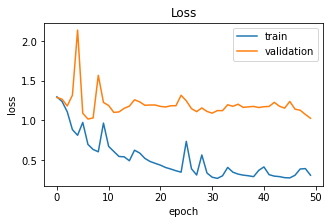

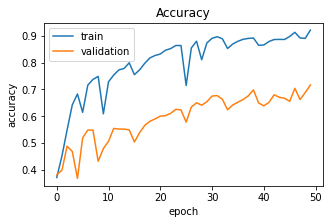

In [8]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()